<a href="https://colab.research.google.com/github/musical-shyam/AirMouse/blob/main/cs480e_2024%2C3f_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3
**Due December 13th, 11:59 PM**

GitHub Classroom assignment link: https://classroom.github.com/a/p0lgkpDj.

Instructions for how to connect your Google Colab to GitHub are [here](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb).

Name: Shyam Kannan<br>
B-Number: B01037711<br>
Email: skannan@binghamton.edu

In the following assignment, you will be using the deep learning framework, PyTorch, to perform computer vision tasks such as image classification and object detection. This will be a report-style assignment, where you will try multiple different models, optimization algorithms, and hyperparameters, and present your findings in a short report with visualizations inside the notebook.  


Functions and cells that need to be implemented are marked with a bold **implement** keyword or clearly marked in the experiments section.

The experiments section for each classifier also need to be implemented. You should follow the instructions above the cell. You may also add additional cells.

Cells marked **run** need to be run to set up the appropriate infrastructure, but do not need to be modified. Make sure you have run the previous cells before running the current cell, or you may get an error.

It is standard practice in ML to share notebooks to discuss the workflow and results in a professional setting. So, the code quality also matters. You should make sure your code is readable and conforms to standard practices. Your figures should be intelligable and include proper axis labels, titles, and legends. Unreadable and poorly written code may result in a points deduction.  

Submission will be via GitHub Classroom. **You are required to have at least 10 commits for this assignment.**

## Uploading and Downloading Data from Colab

Unlike the previous assignments, you will downloading and uploading additional data from and into the Colab environment.

You can mount directories from your Google Drive and use the session storage for your work.

[Take a look here for an example notebook on handling data download and upload on Colab. ](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=hauvGV4hV-Mh)

## Import statements

**Run** the cell to import the packages needed for the code below. You may other packages but ask first.

In [ ]:
import torch
import csv
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
torch.manual_seed(42)  # Set the seed for the random number generator

## CUDA Runtime

You will want to make use of the GPU runtimes on Colab to speed up your training. You can change your runtime by going to:

`Runtime > Change runtime type` and selecting GPU.

You will have to explicitly use the send Torch tensors to GPUs, by calling `.cuda()`  on the tensors and modules to utilize them on the GPU.

[Take a look at the quickstart for PyTorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Part 1: Data Handling in PyTorch (20 pts)

### Dataset class

A large part of any machine learning workflow is the proper and efficient handling of data. Datasets are often large, scattered across filesystems, and require transformations and augmentation. Deep learning libraries such as `PyTorch` provide utilities to help in this process. In the next section, you will write a custom MNIST dataset and add data augmentation to your data pipeline for your traininig.

**Run** the following cell to define some helper functions to load the MNIST data.

In [ ]:
def _data_parser_helper(csv_file_name):
  '''
  Reads CSV file and converts it into numpy arrays.

  Args:
    csv_file_name (string): String of the path of csv file.

  Returns:
    (np.array(float), np.array(int)): Returns a tuple of numpy arrays.
  '''
  X = []
  Y = []
  with open(csv_file_name,'r') as _file:
      csv_reader = csv.reader(_file, delimiter=",")
      for row in csv_reader:
          Y.append(int(row[0]))
          X.append([float(i)/255.0 for i in row[1:]])
  return (np.array(X), np.array(Y))

def get_mnist_train_data():
  X_train, Y_train = _data_parser_helper("sample_data/mnist_train_small.csv")
  return X_train, Y_train

def get_mnist_test_data():
  X_test, Y_test = _data_parser_helper("sample_data/mnist_test.csv")
  return X_test, Y_test

***Implement*** the `MNIST` class to serve as a container for our PyTorch MNIST data. [Take a look at this tutorial on PyTorch datasets, dataloading, and transforms.](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)
[This second, more important tutorial specifically covers custom datasets and dataloaders.](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

The MNIST data on Colab is pre-installed on all notebooks as a CSV.
Your class must read the data and store it as PyTorch float tensors.
Use the helper functions above (already written) to read the data,
which will return the data as NumPy arrays.

You should implement:

- `__init__()` to read the appropriate CSV file, and store it in the class as a `torch.Tensor` with float dtype.
- `__len__()` to return the number of samples in the dataset.
- `__getitem__(i)` to return the i-th sample and label from the data you have stored.

In [ ]:
class MNIST(Dataset):
  """MNIST custom dataset that reads the CSV file and transforms them into PyTorch Tensors"""


  def __init__(self, is_training=True, transform=None):
    """
    Args:
      is_training (bool): If true loads
        the training dataset. If false, loads the test dataset.
        Use the functions above.
      transform (callable): Transform to be applied on a sample.
        These will be used for data augmentations.
    """
    super().__init__() # used basically when there is involvement of inheritance so that the constructors of the parent class called in correct order

    # Checking if it is training or test data and loading accordingly.
    if (is_training):
      self._data, self._label = get_mnist_train_data()
    else:
      self._data, self._label = get_mnist_test_data()

    # Reshaping all the samples in dataset (-1) to the expected shape (28 X 28 X 1) for matrix multiplications
    self._data = torch.from_numpy(self._data.reshape((-1, 1, 28, 28))).float()
    self._label = torch.from_numpy(self._label).float()
    self.transform = transform


  def __len__(self):
    """Returns the size (the number of samples) of the dataset.
    """

    # raise NotImplementedError("The __len__() method was not implemented.")
    return self._data.shape[0]

  def __getitem__(self, i):
    """Returns the i-th sample and label and applies any transforms defined.

      Args:
        i (int): The index of sample in the data array to retrieve.
    """

    # return NotImplementedError("The __getitem__() method was not implemented")

    sample = self._data[i]
    label = self._label[i]
    if (self.transform):
      sample = self.transform(sample)
    return sample, label

In [ ]:
composed = transforms.Compose([transforms.RandomRotation(15)])
mnist_dataset = MNIST(transform=composed)

In [ ]:
from time import perf_counter

In [ ]:
loader = DataLoader(mnist_dataset, batch_size=512, num_workers=2)

In [ ]:
start = perf_counter()
for _data, label in loader:
  x = _data.shape[0]
end = perf_counter()

In [ ]:
print(end-start)

11.877998339999976


***Implement*** the following cell to visualize the data in the dataset. Use `Matplotlib` or your favorite visualization package to plot 5 images of each class in a single figure.

You should initialize a MNIST dataset object for the training class. Visualize this dataset. This will not be used in the future.  



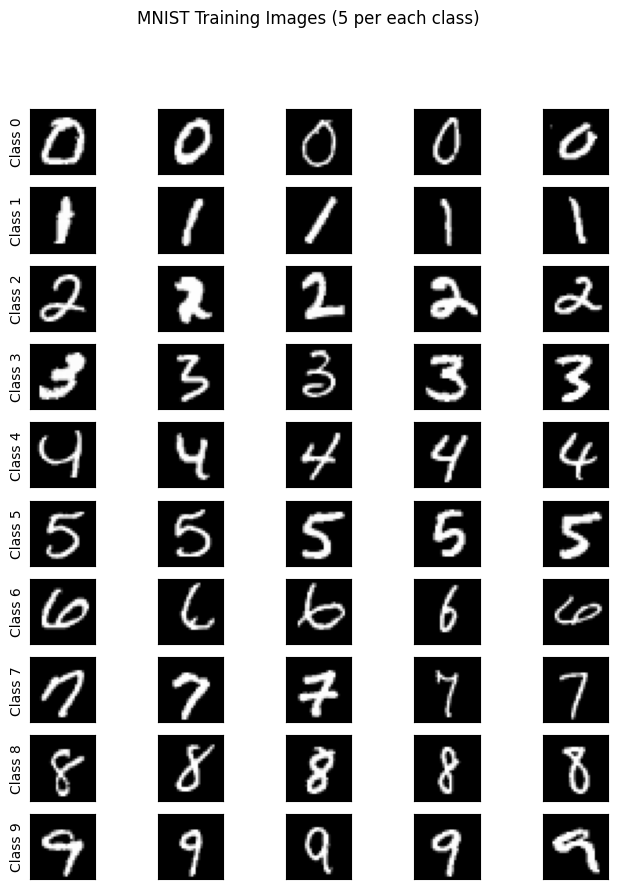

In [ ]:
# Loading the dataset
mnist_dataset = MNIST(is_training=True)

# Creating a Dictionary for each Class
images_per_class = {i : [] for i in range(10)}

# Storing 5 images for each class into the dictionary
for img, label in mnist_dataset:
  # The labels are are also Tensors so converting them into int.
  label_ = int(label.item())
  if len(images_per_class[label_]) < 5:
    images_per_class[label_].append(img)
  if all([len(images_per_class[i]) == 5 for i in range(10)]):
    break

# Plotting the table of images
fig, axes = plt.subplots(10, 5, figsize=(8, 10))
fig.suptitle("MNIST Training Images (5 per each class)")

for i in range(10):
  for j in range(5):
    axes[i, j].imshow(images_per_class[i][j].reshape(28, 28), cmap='gray')
    if j == 0:
            axes[i,j].set_ylabel(f'Class {i}', fontsize=10)
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])

plt.show()

***Implement***
the following cell to create a PyTorch transform object and
assign it to a variable.
You may name the variable whatever you wish;
you will use the object to construct train and test MNIST datasets.

You will use the transformations defined in `torchvision`,
which can be found [here](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor).

Add the `RandomRotation` and `Normalize` transformations to the dataset. You will need to [compose the two transforms](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Compose). Restrict the rotations to +/- 15 degrees.

The mean and standard deviation of the training set is 0.13 and 0.31 respectively.

At the end of the cell, construct a training and test dataset.
Name these carefully, these datasets will be used in the next sections.

In [ ]:
transform  = transforms.Compose([
    transforms.RandomRotation(degrees = (15)),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

mnist_train = MNIST(is_training=True, transform=transform)
mnist_test = MNIST(is_training=False, transform=transform)

***Implement*** the following cell to visualize the data in the dataset with the transformations similar to the previous visualization.

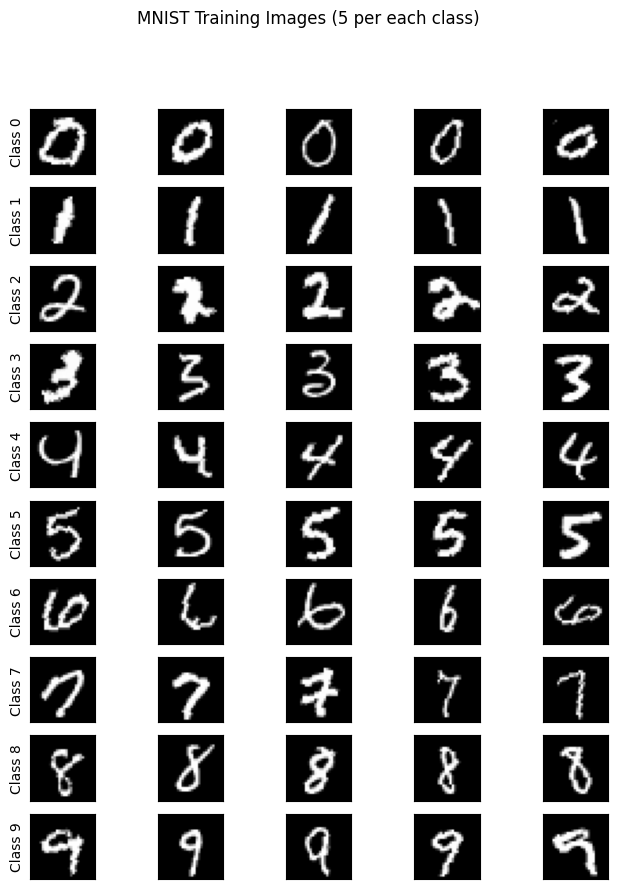

In [ ]:
# Creating a Dictionary for each Class
images_per_class = {i : [] for i in range(10)}

# Storing 5 images for each class into the dictionary
for img, label in mnist_train:
  # The labels are are also Tensors so converting them into int.
  label_ = int(label.item())
  if len(images_per_class[label_]) < 5:
    images_per_class[label_].append(img)
  if all([len(images_per_class[i]) == 5 for i in range(10)]):
    break

# Plotting the graph
fig, axes = plt.subplots(10, 5, figsize=(8, 10))
fig.suptitle("MNIST Training Images (5 per each class)")

for i in range(10):
  for j in range(5):
    axes[i, j].imshow(images_per_class[i][j].reshape(28, 28), cmap='gray')
    if j == 0:
            axes[i,j].set_ylabel(f'Class {i}', fontsize=10)
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])

plt.show()

***Implement*** the following cell to randomly split the training dataset previously defined, and make a training and validation set. Do an 80-20 split for the training and validation set. Name these sets carefully, they will be used in the next section to train your models.

You can use the utilities in `torch.utils.data`.

In [ ]:
from torch.utils.data import random_split
train_len = int(0.8 * len(mnist_train))
val_len = len(mnist_train) - train_len
train_set, val_set = random_split(mnist_train, [train_len, val_len])
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

Training set size: 16000
Validation set size: 4000


## Part 2: MNIST Classification (40 pts)

### Linear Classifiers

The linear classifiers you implemented in the last assignment will serve as our baseline for more powerful convolutional neural networks. You will ***implement*** the multi-class SVM and  Softmax classifiers in the following cells.  

**Implement** a LinearSVM classifier in the following cell. Your implementation should be a python class that inherits from `torch.nn.Module`.

You should use classes and functions defined in `torch.nn` and `torch.nn.Functional`.   

In [ ]:
class LinearSVM(nn.Module):
  ''' Implements the linear SVM using Torch.
  '''
  def __init__(self, num_classes, *args, **kwargs):
    '''
      num_classes (int): The number of output classes
    '''
    super().__init__(*args, **kwargs)
    self.num_classes = num_classes
    self.linear = nn.Linear(28*28, num_classes)
    # raise NotImplementedError("LinearSVM forward not implemented")

  def forward(self, x):
    '''
      x (torch.Tensor): Input image as a torch tensor.
    '''
    x = x.reshape(x.shape[0], -1) # Flattening the inputs to send it into linear layer.
    x = self.linear(x)
    return x
    # raise NotImplementedError("LinearSVM forward not implemented")

***Implement*** using any PyTorch defined optimizer, code to train your LinearSVM classifier on the training dataset. You will want to try different optimizers, learning rates, and batch sizes.

PyTorch provides implementations of various optimization algorithms in the `torch.optim` package. You can use any of the first order methods such as:

- SGD (with or without momentum)
- AdaDelta
- ADAM
- RProp
- RMSProp

***Note:*** You should keep track of the performance of the optimizers, batch sizes, and learning rates. You should justify the choice of your hyperparameters in the report at the end of this section. You will be asked to quantify and visualize the differences between these hyperparameters.

You should use `Torch.utils.data.DataLoader` to do the data loading. Make sure to use the correct loss function. You may use the predefined loss functions available in `Torch.nn`.

***Note:*** As the optimization procedure for training different models is often the same, you should write helper functions that are reusable. This will make your code more readable and reduce the possibility of unexpected bugs.  

To train a single model, you will need to:

- Iterate through the data in batches using your training or validation dataloader
- Perform the forward pass
- Compute the loss
- Perform the backward pass
- Take an optimizer step
- Repeat the process till network converges or some other criterion
- Every n iterations, go through the validation set and calculate the loss and accuracy of the validation set to check your training performance

In [ ]:
def compute_accuracy(output, target):
  preds = torch.argmax(output, dim=1)
  acc = (preds == target).float().mean()
  return acc

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, print_every = 1):
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_epochs):
    # Starting 1 epoch training
    model.train()
    running_loss = 0.0
    running_acc = 0.0


    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      # multi-margin loss in pytorch expects labels to be longTensors
      labels = labels.to(device, dtype=torch.long)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      running_acc += compute_accuracy(outputs, labels)

    avg_train_loss = running_loss / len(train_loader)
    avg_train_acc = running_acc / len(train_loader)

    # Starting the validation of the epoch training
    model.eval()
    running_val_loss = 0.0
    running_val_acc = 0.0


    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs = inputs.to(device)
        # multi-margin loss in pytorch expects labels to be longTensors
        labels = labels.to(device, dtype=torch.long)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()
        running_val_acc += compute_accuracy(outputs, labels)


    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_acc = running_val_acc / len(val_loader)

    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    if epoch % print_every == 0:
      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
      f"Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

  return train_losses, train_accuracies, val_losses, val_accuracies

def run_experiments(optimizers, model_class, learning_rates, batch_sizes, criterion, epochs = 10):
  results = {}
  for opt_name, opt_class in optimizers.items():
    for lr in learning_rates:
      for bs in batch_sizes:
        train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=bs, shuffle=False)

        model = model_class(10).to(device)
        optimizer = opt_class(model.parameters(), lr=lr)

        print_every = epochs // 10 if epochs >= 10 else 1
        print(f"\nRunning {opt_name} with learning rate {lr} and batch size {bs}")
        train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=epochs, print_every=print_every)

        results[(opt_name, lr, bs)] = {'train_loss': train_losses, 'train_acc': train_accuracies, 'val_loss': val_losses, 'val_acc': val_accuracies}
  return results



In [ ]:
# HyperParameters
criterion = nn.MultiMarginLoss() # multi-class hinge loss provided by pytorch
epochs = 10
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'RMSProp': torch.optim.RMSprop
}
learning_rate = [0.01, 0.001, 0.0005]
batch_size = [32, 64]
model = LinearSVM
SVM_results = run_experiments(optimizers, model, learning_rate, batch_size, criterion, epochs)


Running SGD with learning rate 0.01 and batch size 32
Epoch 1/10, Train Loss: 0.1176, Train Acc: 0.8048, Val Loss: 0.0744, Val Acc: 0.8583
Epoch 2/10, Train Loss: 0.0695, Train Acc: 0.8641, Val Loss: 0.0642, Val Acc: 0.8777
Epoch 3/10, Train Loss: 0.0626, Train Acc: 0.8751, Val Loss: 0.0634, Val Acc: 0.8773
Epoch 4/10, Train Loss: 0.0598, Train Acc: 0.8789, Val Loss: 0.0599, Val Acc: 0.8827
Epoch 5/10, Train Loss: 0.0586, Train Acc: 0.8794, Val Loss: 0.0566, Val Acc: 0.8840
Epoch 6/10, Train Loss: 0.0559, Train Acc: 0.8850, Val Loss: 0.0546, Val Acc: 0.8873
Epoch 7/10, Train Loss: 0.0554, Train Acc: 0.8841, Val Loss: 0.0554, Val Acc: 0.8840
Epoch 8/10, Train Loss: 0.0550, Train Acc: 0.8875, Val Loss: 0.0556, Val Acc: 0.8875
Epoch 9/10, Train Loss: 0.0525, Train Acc: 0.8900, Val Loss: 0.0533, Val Acc: 0.8925
Epoch 10/10, Train Loss: 0.0528, Train Acc: 0.8874, Val Loss: 0.0544, Val Acc: 0.8857

Running SGD with learning rate 0.01 and batch size 64
Epoch 1/10, Train Loss: 0.1482, Train A

**Implement** a Softmax classifier in the following cell. Your implementation should be a python class that inherits from `torch.nn.Module`.

In [ ]:
class Softmax(nn.Module):
  ''' Implements the softmax classifier using Torch.'''
  def __init__(self, num_classes, *args, **kwargs):
    '''
      num_classes (int): The number of output classes
    '''
    super().__init__(*args, **kwargs)
    self.num_classes = num_classes
    self.linear = nn.Linear(28*28, num_classes)
    # raise NotImplementedError("Softmax forward not implemented")

  def forward(self, x):
    '''
      x (torch.Tensor): Input image as a torch tensor.
    '''
    x = x.reshape(x.shape[0], -1) # Flattening the inputs to send it into linear layer.
    x = self.linear(x)
    return x
    # raise NotImplementedError("Softmax forward not implemented")

***Implement*** using any PyTorch defined optimizer, train your Softmax classifier on the training dataset and validate on the validation dataset, as you did before.

***Note:*** You should keep track of the performance of the optimizers, batch sizes, and learning rates. You should justify the choice of your hyperparameters in the report at the end of this section. You will be asked to quantify and visualize the differences between these hyperparameters.

You will want to try different optimizers, learning rates, and batch sizes. You should use `Torch.DataLoader` to simplify the data loading. Make sure to use the correct loss function. You may use predefined loss functions available in `Torch.nn`.

Same as before, to train a single model, you will need to:

- Iterate through the data in batches using your training or validation dataloader
- Perform the forward pass
- Compute the loss
- Perform the backward pass
- Take an optimizer step
- Repeat the process till network converges or some other criterion
- Every n iterations, go through the validation set and calculate the loss and accuracy of the validation set to check your training performance

In [ ]:
# HyperParameters
criterion = nn.CrossEntropyLoss() # multi-class hinge loss provided by pytorch
epochs = 10
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'RMSProp': torch.optim.RMSprop
}
learning_rate = [0.01, 0.001, 0.0005]
batch_size = [32, 64]
model = Softmax
Softmax_results = run_experiments(optimizers, model, learning_rate, batch_size, criterion, epochs)


Running SGD with learning rate 0.01 and batch size 32
Epoch 1/10, Train Loss: 0.6342, Train Acc: 0.8231, Val Loss: 0.4427, Val Acc: 0.8765
Epoch 2/10, Train Loss: 0.4361, Train Acc: 0.8754, Val Loss: 0.4075, Val Acc: 0.8852
Epoch 3/10, Train Loss: 0.4063, Train Acc: 0.8816, Val Loss: 0.3930, Val Acc: 0.8860
Epoch 4/10, Train Loss: 0.3895, Train Acc: 0.8869, Val Loss: 0.3740, Val Acc: 0.8892
Epoch 5/10, Train Loss: 0.3781, Train Acc: 0.8900, Val Loss: 0.3685, Val Acc: 0.8917
Epoch 6/10, Train Loss: 0.3759, Train Acc: 0.8894, Val Loss: 0.3777, Val Acc: 0.8895
Epoch 7/10, Train Loss: 0.3714, Train Acc: 0.8944, Val Loss: 0.3844, Val Acc: 0.8890
Epoch 8/10, Train Loss: 0.3661, Train Acc: 0.8945, Val Loss: 0.3617, Val Acc: 0.8940
Epoch 9/10, Train Loss: 0.3591, Train Acc: 0.8958, Val Loss: 0.3505, Val Acc: 0.8995
Epoch 10/10, Train Loss: 0.3543, Train Acc: 0.8979, Val Loss: 0.3611, Val Acc: 0.8935

Running SGD with learning rate 0.01 and batch size 64
Epoch 1/10, Train Loss: 0.7750, Train A

In [ ]:
# model_2 = train_model(model_2, train_loader, val_loader, criterion_2, optimizer_2, num_epochs=epochs_2, print_every=1)

Epoch 1/10, Train Loss: 2.5268, Train Acc: 0.0824, Val Loss: 2.5088, Val Acc: 0.0952
Epoch 2/10, Train Loss: 2.5234, Train Acc: 0.0859, Val Loss: 2.5138, Val Acc: 0.0952
Epoch 3/10, Train Loss: 2.5278, Train Acc: 0.0842, Val Loss: 2.5174, Val Acc: 0.0900
Epoch 4/10, Train Loss: 2.5232, Train Acc: 0.0853, Val Loss: 2.5141, Val Acc: 0.0875
Epoch 5/10, Train Loss: 2.5235, Train Acc: 0.0873, Val Loss: 2.5110, Val Acc: 0.0878
Epoch 6/10, Train Loss: 2.5225, Train Acc: 0.0854, Val Loss: 2.5103, Val Acc: 0.0895
Epoch 7/10, Train Loss: 2.5256, Train Acc: 0.0854, Val Loss: 2.5131, Val Acc: 0.0970
Epoch 8/10, Train Loss: 2.5273, Train Acc: 0.0836, Val Loss: 2.5125, Val Acc: 0.0905
Epoch 9/10, Train Loss: 2.5216, Train Acc: 0.0834, Val Loss: 2.5162, Val Acc: 0.0905
Epoch 10/10, Train Loss: 2.5271, Train Acc: 0.0819, Val Loss: 2.5089, Val Acc: 0.0905


***Implement*** visualizations in the following cell to show performance differences of the different hyperparameters.

***Include*** visualizations for the effect of different batch sizes, learning rates, and optimizers. You are free to choose any method of visualization as long as it is able to succintly convey your justifications.

In [ ]:
def plot_results(results):
  optimizers = sorted(set([k[0] for k in results.keys()]))
  learning_rates = sorted(set([k[1] for k in results.keys()]))
  batch_sizes = sorted(set([k[2] for k in results.keys()]))

  # creating the plot labels
  metrics_labels = [('train_loss', 'Training Loss', 'Loss'),
        ('val_loss', 'Validation Loss', 'Loss'),
        ('train_acc', 'Training Accuracy', 'Accuracy'),
        ('val_acc', 'Validation Accuracy', 'Accuracy')]

  # creating a figure with one row per optimizer and one column per metric
  fig, axes = plt.subplots(nrows=len(optimizers), ncols=len(metrics_labels), figsize=(20, 5 * len(optimizers)))

  if len(optimizers) == 1:
    axes = [axes]

  for i, opt in enumerate(optimizers):
    for j, (x_label, title, y_label) in enumerate(metrics_labels):
      ax = axes[i][j]
      for (opt_name, lr, bs), res in results.items():
        if opt_name == opt:
          epochs = range(1, len(res[x_label]) + 1)
          ax.plot(epochs, res[x_label], marker='o', linestyle='-',
                            label=f"lr={lr}, bs={bs}")
      ax.set_title(f"{title} for {opt}")
      ax.set_xlabel("Epoch")
      ax.set_ylabel(y_label)
      ax.legend()

  plt.tight_layout()
  plt.show()

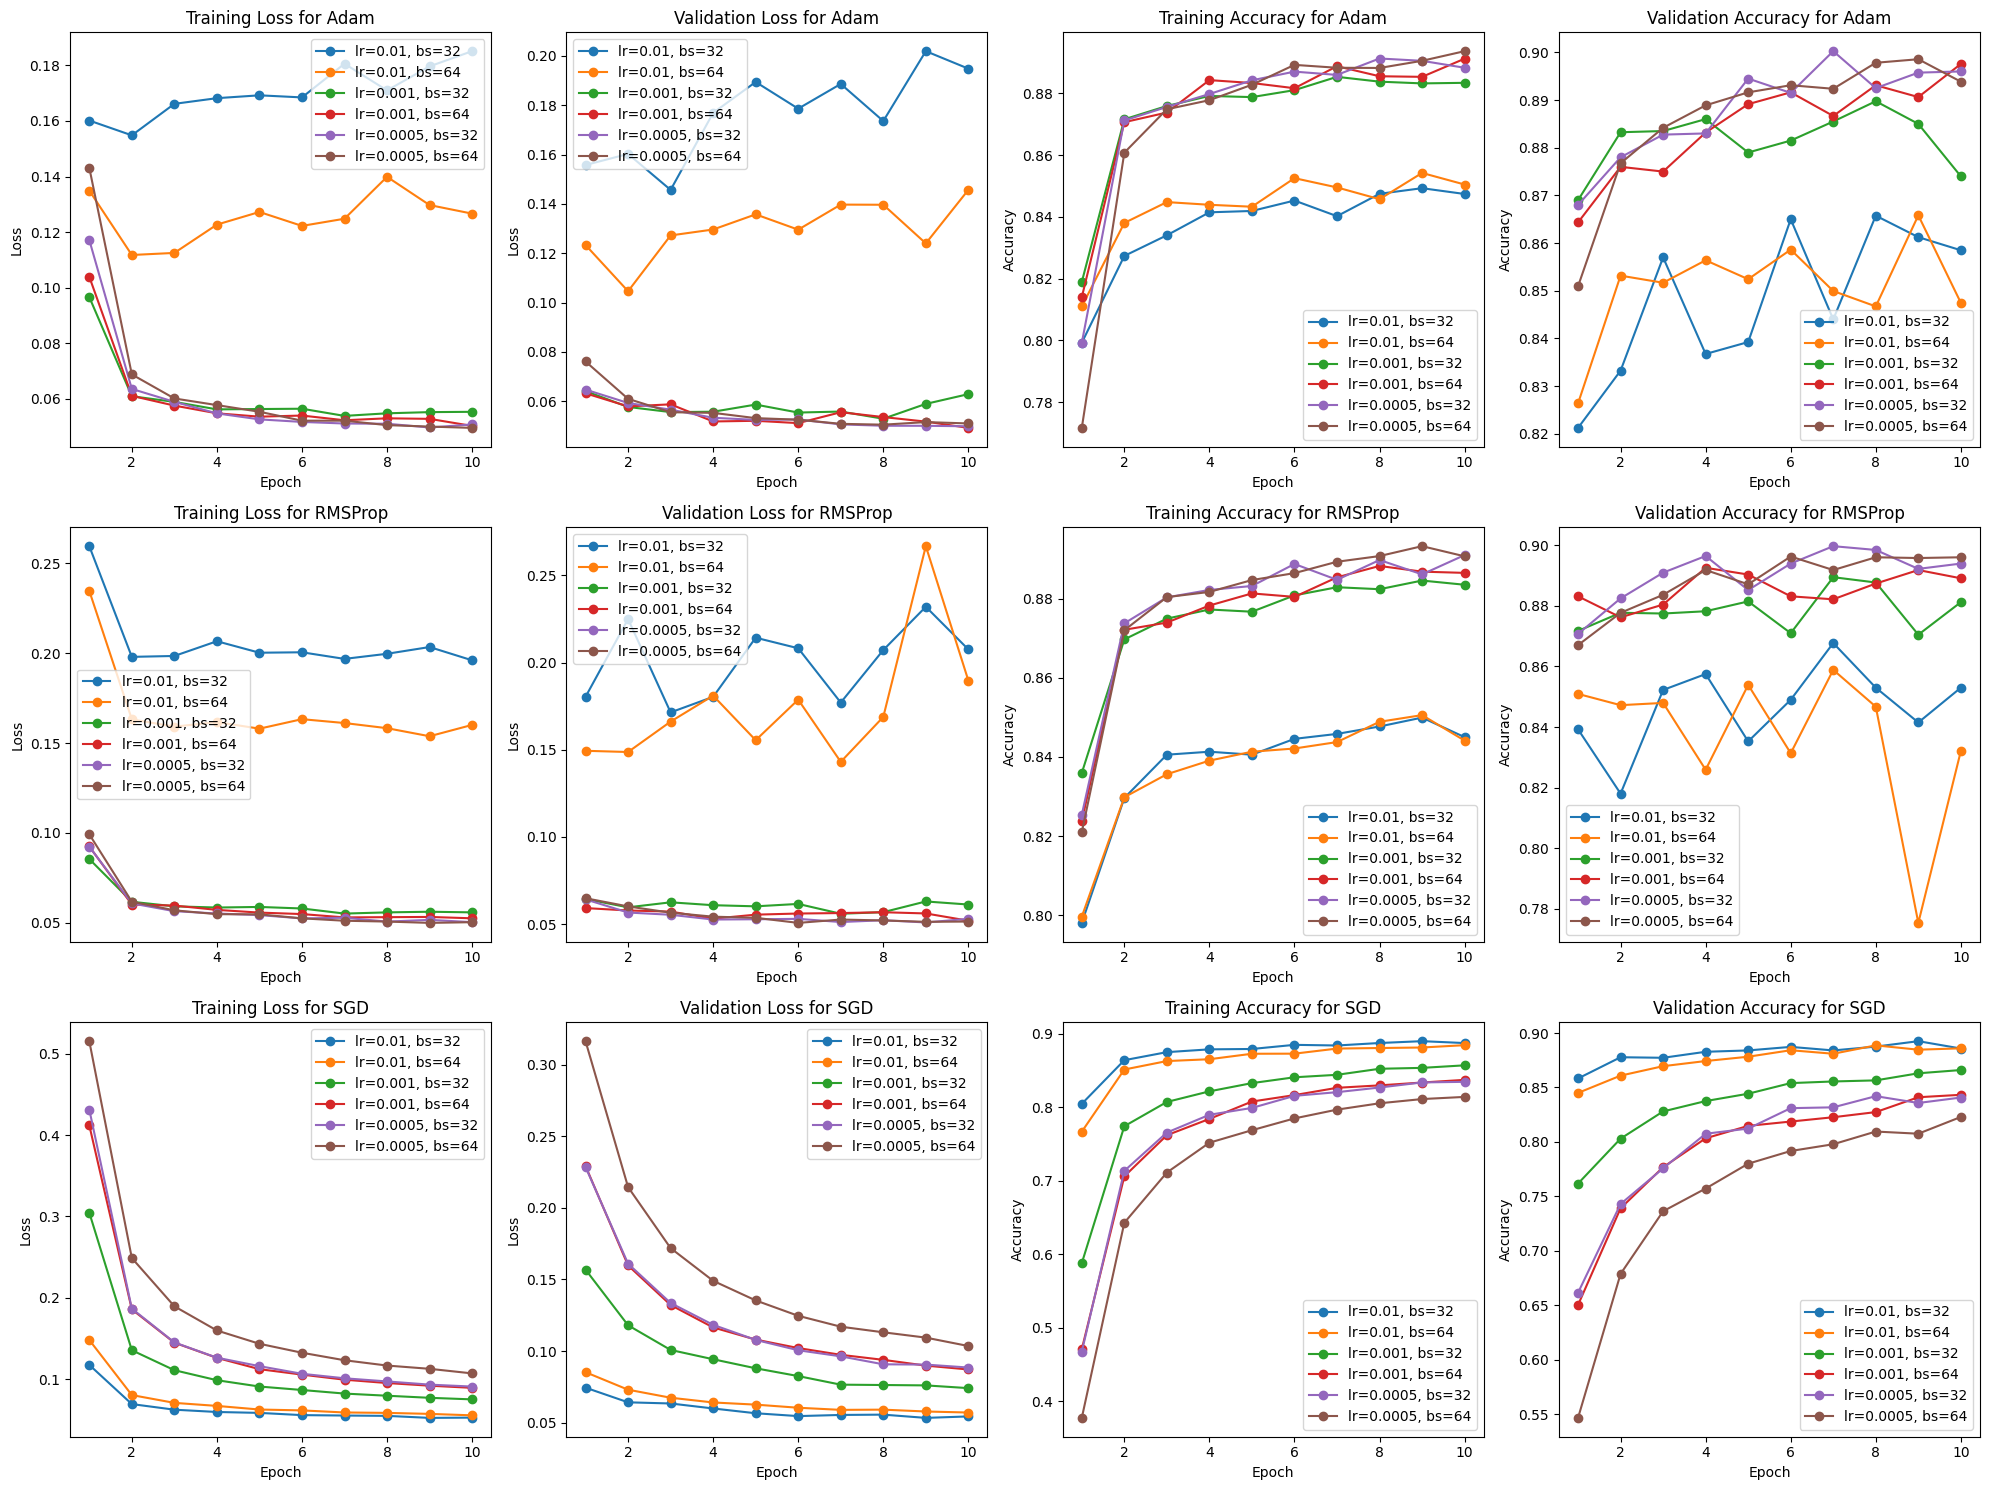

In [ ]:
plot_results(SVM_results)

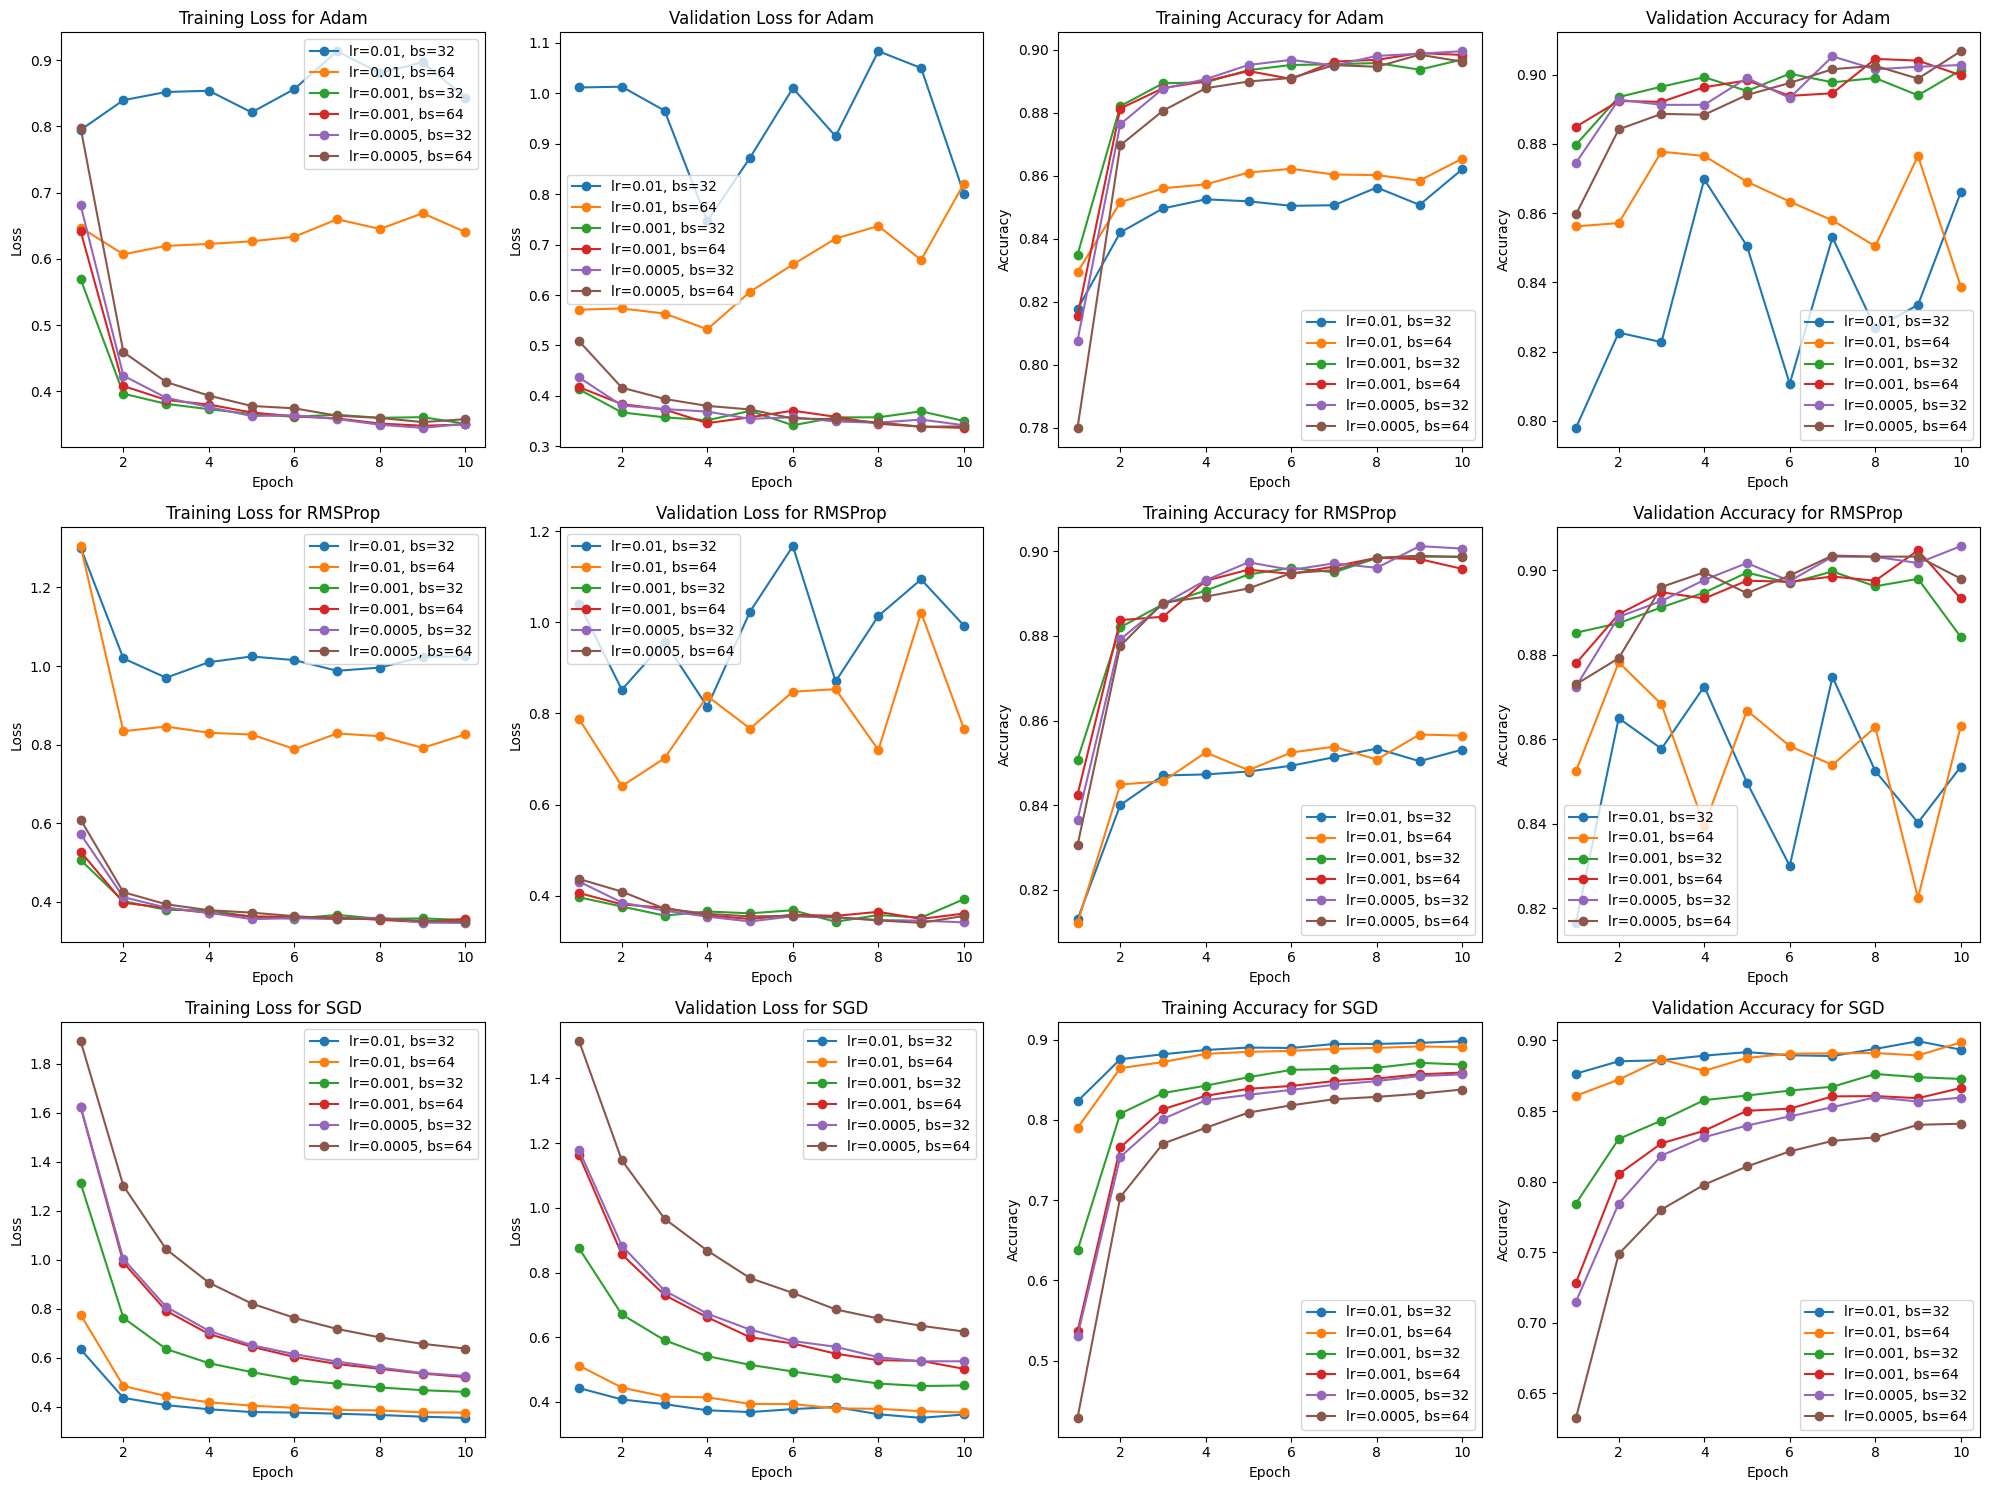

In [ ]:
plot_results(Softmax_results)

### Convolutional Neural Networks

***Implement*** the following cell to implement a convolutional neural network. Similar to before, your implementation should be a Python class that inherits from `torch.nn.Module`.

Your model can use any of the building blocks defined in `torch.nn` including but not limited to:

- Conv2D
- Linear
- Activation layers:
  - ReLU
  - Tanh
  - Sigmoid
  - Softmax
- Normalization layers:
  - BatchNorm
  - LayerNorm
  - GroupNorm
- Pooling layers:
  - MaxPool
  - AvgPool
- Dropout

Make sure to chose the correct dimensional versions of the layers, i.e for images use MaxPool2d and vectors use MaxPool1d


Example LeNet implementation:

```python
class LeNet(nn.Module):

    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        
        # num_classes number of output classes
        self.num_classes = num_classes
        # 1 input image channel,
        # 6 output channels
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        # ReLU activation function
        self.act1 = nn.ReLU()
        # Max pooling with 2x2 square kernel
        self.pool1 = nn.MaxPool2d(2)
        
        # Second convolution with 6 input image channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        # 3 Layer fully connected layer
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        
        # First Convolution -> Activation -> Max Pooling
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # Second Convolution -> Activation -> Max Pooling
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)

        # Three layer MLP with ReLU activations
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

```

In the following cells, perform experiments using the CNN you defined. You may need to reshape your data in order to 2D convolutions.

Your objective is to find the best architecture that minimizes the error but using as few a parameters and FLOPS as possible.

***Performance matters!*** The model with the best combination of high accuracy, parameter, and compute efficiency will get extra credit (15 pts).

In [22]:
class CNN(nn.Module):
  ''' Implements the CNN using Torch.'''
  def __init__(self, num_classes, *args, **kwargs):
    '''
      num_classes (int): The number of output classes
    '''
    super().__init__(*args, **kwargs)
    self.features = nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels=32, kernel_size=3, padding=1), # Size of each batch data: [N, 1, 28, 28] --> [N, 32, 28, 28]
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # [N, 32, 28, 28] --> [N, 64, 28, 28]
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2), # [N, 64, 28, 28] --> [N, 64, 14, 14]
        nn.Dropout(0.25),
    )
    self.classifier = nn.Sequential(
        nn.Linear(64 * 14 * 14, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )

  def forward(self, x):
    '''
      x (torch.Tensor): Input image as a torch tensor.
    '''
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

print("CNN model:")
print(CNN(10))

CNN model:
CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


**Implement** the following cell to compute and compare the test set performance (accuracy) of the linear classifiers and CNN.

In [23]:
criterion = nn.CrossEntropyLoss()
epochs = 3
model = CNN
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'RMSProp': torch.optim.RMSprop
}
batch_size = [32, 64]
learning_rate = [0.01, 0.001, 0.0005]
CNN_results = run_experiments(optimizers, model, learning_rate, batch_size, criterion, epochs)


Running SGD with learning rate 0.01 and batch size 32
Epoch 1/3, Train Loss: 0.8504, Train Acc: 0.7294, Val Loss: 0.3685, Val Acc: 0.8928
Epoch 2/3, Train Loss: 0.4556, Train Acc: 0.8595, Val Loss: 0.2834, Val Acc: 0.9197
Epoch 3/3, Train Loss: 0.3726, Train Acc: 0.8833, Val Loss: 0.2226, Val Acc: 0.9302

Running SGD with learning rate 0.01 and batch size 64
Epoch 1/3, Train Loss: 1.0101, Train Acc: 0.6896, Val Loss: 0.4126, Val Acc: 0.8782


KeyboardInterrupt: 

In the following cells ***write*** a short justification on how you came up with your final model and architecture. You may include details like:

- Which optimizer did you use? Why did you use that?
- What about the other hyperparameters?
- Did you base your model on an existing architecture?
- What changes did you make to improve accuracy?
- What changes did you make to improvde performance?

***Include*** visualizations for the effect of different batch sizes, learning rates, and optimizers. You are free to choose any method of visualization as long as it is able to succintly convey your justifications.

Dropout, Multiple Conv Layers like VGG net,

In [ ]:
plot_results(CNN_results)

In [38]:
def print_sorted_results(results):
  table = []
  for (opt, lr, bs), metrics in results.items():
      final_train_acc = metrics['train_acc'][-1]  # last epoch's accuracy
      final_val_acc = metrics['val_acc'][-1]  # last epoch's accuracy
      table.append((opt, lr, bs, final_train_acc, final_val_acc))

  # Sort by final_train_acc descending
  table.sort(key=lambda x: x[4], reverse=True)

  # Print in a simple table format
  print("Optimizer | LR     | Batch Size | Final Train Acc | Final Val Acc")
  print("----------|--------|------------|-----------------|--------------")
  for row in table:
      opt, lr, bs, acc, val_acc = row
      print(f"{opt:<9} | {lr:<6} | {bs:<10} | {acc:<15.4f} | {val_acc:<14.4f}")

In [39]:
print("SVM Results: \n")
print_sorted_results(SVM_results)

SVM Results: 

Optimizer | LR     | Batch Size | Final Train Acc | Final Val Acc
----------|--------|------------|-----------------|--------------
Adam      | 0.001  | 64         | 0.8913          | 0.8976        
RMSProp   | 0.0005 | 64         | 0.8907          | 0.8961        
Adam      | 0.0005 | 32         | 0.8883          | 0.8960        
RMSProp   | 0.0005 | 32         | 0.8910          | 0.8940        
Adam      | 0.0005 | 64         | 0.8937          | 0.8938        
RMSProp   | 0.001  | 64         | 0.8865          | 0.8891        
SGD       | 0.01   | 64         | 0.8846          | 0.8859        
SGD       | 0.01   | 32         | 0.8874          | 0.8857        
RMSProp   | 0.001  | 32         | 0.8835          | 0.8813        
Adam      | 0.001  | 32         | 0.8834          | 0.8740        
SGD       | 0.001  | 32         | 0.8571          | 0.8660        
Adam      | 0.01   | 32         | 0.8474          | 0.8585        
RMSProp   | 0.01   | 32         | 0.8450         

In [40]:
print("Softmax Results: \n")
print_sorted_results(Softmax_results)

Softmax Results: 

Optimizer | LR     | Batch Size | Final Train Acc | Final Val Acc
----------|--------|------------|-----------------|--------------
Adam      | 0.0005 | 64         | 0.8962          | 0.9067        
RMSProp   | 0.0005 | 32         | 0.9007          | 0.9057        
Adam      | 0.0005 | 32         | 0.8995          | 0.9028        
Adam      | 0.001  | 32         | 0.8969          | 0.9013        
Adam      | 0.001  | 64         | 0.8983          | 0.8998        
SGD       | 0.01   | 64         | 0.8904          | 0.8986        
RMSProp   | 0.0005 | 64         | 0.8986          | 0.8981        
SGD       | 0.01   | 32         | 0.8979          | 0.8935        
RMSProp   | 0.001  | 64         | 0.8959          | 0.8934        
RMSProp   | 0.001  | 32         | 0.8988          | 0.8842        
SGD       | 0.001  | 32         | 0.8688          | 0.8727        
SGD       | 0.001  | 64         | 0.8588          | 0.8663        
Adam      | 0.01   | 32         | 0.8621     

## Part 3: Real World Data (40 pts)

While test set accuracy is meant to approximate the perfomance in real world data, biases in data collection and processing often result in inaccurate performance estimates. In this section, you will be using the previously defined models to re-train on the data the class has collected.

In user systems, noisy inputs are often likely. To make your model robust to faulty input, you will need to add an additional class to your model which corresponds to the label 10. This label is reserved for inputs that are **not** digits.


***Implement*** the following cells to load and convert the new dataset and combine the new dataset with old dataset.  

Make sure you have downloaded the `MNIST580E_training.csv` and `MNIST580E_test.csv` files from the shared drive and uplodaded it to your GDrive. You will be combining our collected data with the MNIST dataset available with Colab.

You will need to:


- Mount your GDrive
- Load the `MNIST580E_training.csv` and `MNIST580E_test.csv` files
- Parse the files and create train and test datasets as you did previously
  - Make sure to normalize the data and add data augmentation. You are free to use any augmentation you'd like.
- Combine the new datasets with the dataset available on Colab.
  - You can use the `ConcatDataset` or `ChainDataset`.  
- Visualize the newly created data. This should serve as a sanity check for your newly written data pipeline.

**Data Augmentation:**

The collected data will have more variability compared to the original dataset.
So you should make heavy use of data augmentation on the collected dataset. You can use augmentations such as as:

- Rotation
- Resize
- Blur
- Perspective shift

**Another hint:** Since we are adding an additional class type (not a digit), our dataset will be imbalanced. There will be fewer samples with that label compared to other labels. You may want to "double count" (i.e duplicate) the not-a-digit samples in your collected dataset.

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
training_path = '/content/drive/My Drive/Colab Notebooks/CS 480E: Introduction to Deep Learning/Datasets/MNIST580E_training.csv'
test_path = '/content/drive/My Drive/Colab Notebooks/CS 480E: Introduction to Deep Learning/Datasets/MNIST580E_test.csv'

In [46]:
def load_datasets(csv_file_path):
  X = []
  y = []
  with open(csv_file_path, 'r') as csv_file:
    for line in csv_file:
      row = line.strip().split(',')
      label = int(row[0])
      image = np.array([int(pixel) for pixel in row[1:]]).reshape(28, 28)
      X.append(image)
      y.append(label)
  return np.array(X), np.array(y)

In [47]:
X_train, y_train = load_datasets(training_path)
X_test, y_test = load_datasets(test_path)

print('New Training Data shape: ',X_train.shape, y_train.shape)
print('New Testing Data Shape: ',X_test.shape, y_test.shape)

New Training Data shape:  (710, 28, 28) (710,)
New Testing Data Shape:  (490, 28, 28) (490,)


**Implement** the following cell to use your previously trained CNN as a feature extractor. This is an example of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning).

You will need to:
- Freeze the layers of convolutional model you trained
- Change the final linear layer have an additional output for the additional class.  

Here's an example of taking the previously defined LeNet and updating the final layer to have 11 classes instead of 10. This also freezes the other weights in the LeNet.

```python
# model_conv is a trained LeNet example from above

# Freeze the weights of the model
# The gradients will not be calculated and the optimizer will not
# update the weights
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc3.in_features
model_conv.fc3 = nn.Linear(num_ftrs, 11)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized not the other weights
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001)
```


**Implement** the following cell to train the final layer of the convolution. Also calculate the test set performance on this fine-tuned model.

***Implement*** the following cell to retrain the linear classifiers (LinearSVM and Softmax). Note that you have an extra class as your model should also detect "not a digit".

***Implement*** the following cell to retrain your previously defined CNN model.

**Implement** a visualization of the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) on the **new** combined test set with the predictions from your LinearSVM, Softmax, and CNN. You should use a single `Matplotlib` figure with multiple subplots on a single row.

[See here for examples on using plt.subplots.](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)

In the following cells, write a short report about the performance of your models. You should include the effects of new data, data augmentation, and different architectures. You should also include visualizations as you did before.